In [1]:
import numpy as np
from pylab import *
%matplotlib inline
from plot_fredda import load4d
import sigproc
import os
import fdmt
reload(fdmt)


<module 'fdmt' from '/Users/ban115/bolton/craft/code/python/fdmt.pyc'>

# Make a time/freqency ramp
Use this as a debug filterbank to use with FREDDA - we'll turn off fredda rescaling so it comes in verbatim

In [2]:
nchan = 336
nsamp = 4096*2
nt = 256
nd = 1024
fch1 = 1448.0-336
tsamp = 0.001265625
tframp = np.zeros((nsamp, nchan), dtype=np.float32)
for t in range(nsamp):
    for c in range(nchan):
        tframp[t,c] = float(c) + float(t)/1000

In [3]:
 hdr = {'source_name':'test',
           'tsamp': tsamp,
           'pulsarcentric':0,
           'az_start':1.,
           'nbits':32,
           'foff':1.0,
           'fch1':fch1,
           'nchans': nchan,
           'telescope_id':1,
           'src_dej': -30724.3618819,
           'src_raj': 164015.762746,
           'tstart':57681.5338261,
           'nifs':1
       }

In [5]:
fout = 'tframp.fil'
sfile = sigproc.SigprocFile(fout, 'w', hdr)
sfile.seek_data(0)
tframp.flatten().tofile(sfile.fin)
sfile.fin.flush()
sfile.fin.close()

# Run FREDDA

compfile freadda with -DDUMP_STATE=1 or uncomment the line in fdmt.h

run fredda with 
cudfadmt -t 256 -d 1024 -R -D -r 0


# Check initialisation

In [44]:
d = tframp
thedir = '/data/TETHYS_1/ban115/testdata/sim_tframp'
s = load4d(os.path.join(thedir, 'state_e0_s0.dat'))
dinit = d[:s.shape[-1], ::].T # pull out first nt samples and invert chanenls, that's what fredda does
print(s.shape)

/data/TETHYS_1/ban115/testdata/sim_tframp/state_e0_s0.dat (1, 336, 6, 256) 1 Nzeros= 5041 max/min/mean/sum 2011.51501465/0.0/579.057067871/298849024.0 max at (0, 335, 5, 255) NaNs? 0 Ninfs?= 0
(1, 336, 6, 256)


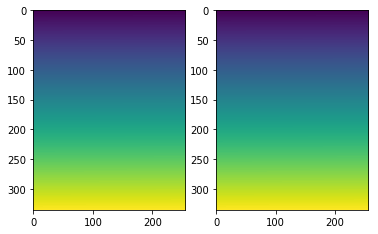

In [45]:
fig, axs = subplots(1,2)
axs[0].imshow(s[0,:,0,:])
axs[1].imshow(dinit)

In [46]:
# Has fredda loaded up my file properly?
np.all(s[0,:,0,:] == dinit)

True

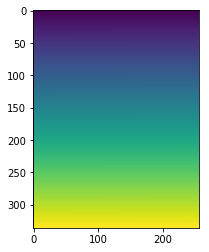

In [47]:
# OK, here's the tricky one.
s1 = s[0,:,1,:] # idt=1
imshow(s1)

In [48]:
import importlib
importlib.reload(fdmt)
thefdmt = fdmt.Fdmt(fch1,1.0, nchan, nd, nt)

c = 0


In [49]:
initexpected = thefdmt.initialise(tframp[:nt,:].T)

In [50]:
# the python FDMT is strictuly more correct
# in that it computes the slightly longer times. We'll only check the first nt samples
initexpected.shape

(336, 6, 262)

In [51]:
s.shape

(1, 336, 6, 256)

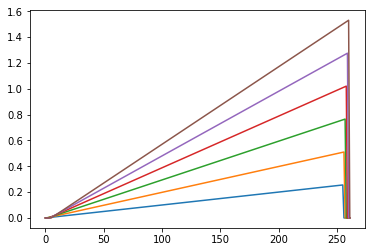

In [52]:
_ = plot(initexpected[c,:,:].T)

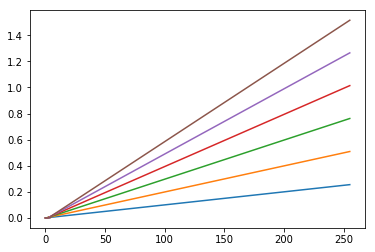

In [53]:
_ = plot(s[0,c,:,:].T)

False
[0.    0.001 0.003 0.005]


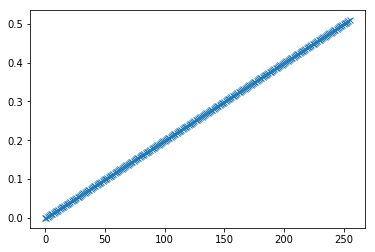

In [55]:
idt = 1
_ = plot(s[0,c,idt,:].T,'x')
print(np.all(s[0,c,idt,:4].T == 0))
print(s[0,c,idt,:4].T)


(8192, 336)
0.5090000033378601


False

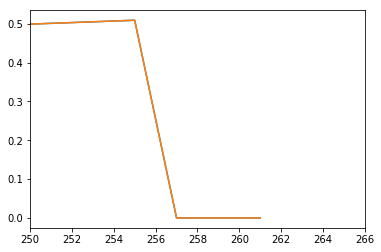

In [56]:
print(d.shape)
# Barak's code is:
#    for i_dT in xrange(1,deltaT+1):
#        Output[:,i_dT,i_dT:] = Output[:,i_dT-1,i_dT:] + Image[:,:-i_dT]
db = tframp[:nt, :]
outshape = initexpected.shape
state = np.zeros(outshape, dtype=np.float32)
idt = 0
dint = d[0:nt, :].T
din = d[0:nt,:]
state[:, 0, 0:nt] = dint
for idt in range(1, 6):
    state[:, idt, idt:idt+nt] = state[:, idt-1, idt:idt+nt] + dint

myexpect = np.zeros((nt+6, nchan))
myexpect[0, :] = d[0, :]
myexpect[1:nt, :] = din[0:nt-1,:] + din[1:nt,:]
myexpect[nt,:] = din[nt-1, :]

plot(myexpect[:, 0])
plot(state[0, 1, :])
xlim(250,266)
print(myexpect[:,0].max())
np.all(myexpect == state[:, 1, :].T)

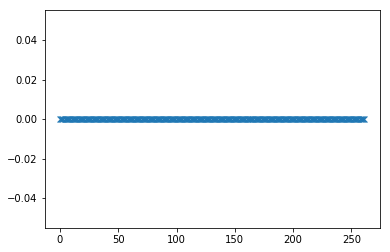

In [57]:
plot(myexpect[:, c] - state[c, 1, :].T, 'x')

In [58]:
np.where(myexpect[:, c] !=state[c, 1, :].T)

(array([], dtype=int64),)

0 256
(336, 6, 262) (1, 336, 6, 256)
Perfectly equal? False
Approximately equal? True
Worst error 0.00024414062 at (256, 4, 28)


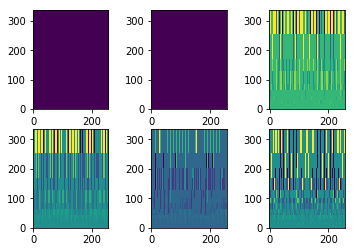

In [59]:
print(c, nt)
print(state.shape, s.shape)
fredda_diff = state[:, :, 0:nt] - s[0,:,:,:]
print('Perfectly equal?', np.all(fredda_diff == 0))
print('Approximately equal?', np.all(abs(fredda_diff) < 1e-3))
print('Worst error', np.max(abs(fredda_diff)), 'at', np.unravel_index(np.argmax(abs(fredda_diff)), fredda_diff.shape))
fig, axs = subplots(2,3)
for iax, ax in enumerate(axs.flatten()):
    ax.imshow(fredda_diff[:,iax,:], origin='lower')

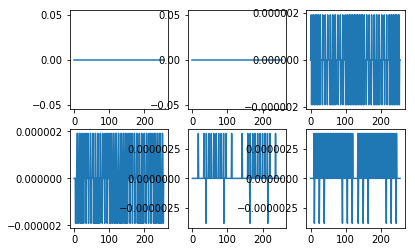

In [60]:
fig, axs = subplots(2,3)
for iax, ax in enumerate(axs.flatten()):
    ax.plot(fredda_diff[7, iax,:].T)

(0, 10)

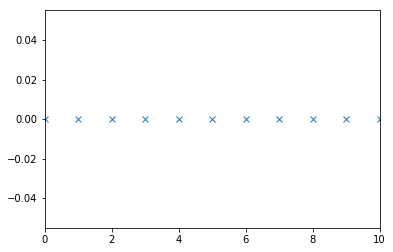

In [61]:
plot(fredda_diff[0, 1, :], 'x')
xlim(0, 10)

idt=1
tplot = slice(0,5)
plot(state[c, idt, tplot ], 'bx', label='Python')
plot(s[0, c, idt, tplot ], 'ro', label='Fredda')
legend()

In [62]:
print('*'*16 + 'IS FREDDA INITIALISATION CONSISTENT WITH PYTHON?' + '*'*16)
print(np.all(abs(fredda_diff) < 1e-3))
np.where(abs(fredda_diff)>1e-3)

****************IS FREDDA INITIALISATION CONSISTENT WITH PYTHON?****************
True


(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

OK - so all errors are < 1e-3 - which is the resolution of the input (recall value=channel + time/1000) - that's OK but I was hoping it would be exactly.

# Check FDMT hits

In [104]:
fredda_weights = load4d(os.path.join(thedir, 'fdmtweights.dat'))[0,0,0,:]

/data/TETHYS_1/ban115/testdata/sim_tframp/fdmtweights.dat (1, 1, 1, 1024) 1 Nzeros= 0 max/min/mean/sum 0.0546358376741/0.0386333689094/0.0470976531506/48.2279968262 max at (0, 0, 0, 242) NaNs? 0 Ninfs?= 0


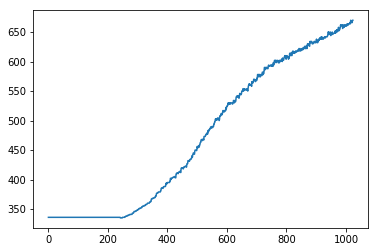

In [105]:
fredda_hitcount = 1/fredda_weights**2
plot(fredda_hitcount)

In [4]:
import importlib
ones = np.ones((nchan, nt))
osum = fdmt.OverlapAndSum(nd, nt, dtype=np.float32)
print(fch1, nchan, nd, nt)
# AARGH!@ Why do I have to add 0.5?
importlib.reload(fdmt)
thefdmt = fdmt.Fdmt(float(fch1)-0.5,1.0, nchan, nd, nt)
print(thefdmt)

nblocks = nd/nt

for blk in range(nblocks+1):
    fout = thefdmt(ones)
    oout = osum(fout)
       

1112.0 336 1024 256


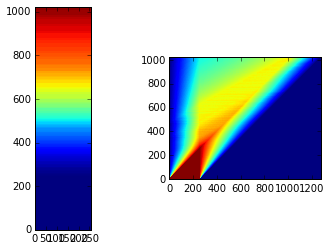

In [5]:
fig, axs = subplots(1,2)
axs[0].imshow(oout, origin='lower')
axs[1].imshow(fout, origin='lower')

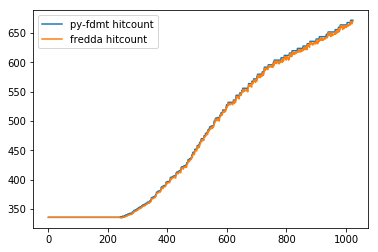

In [108]:
plot(oout[:,0], label='py-fdmt hitcount')
plot(fredda_hitcount, label='fredda hitcount')
legend()

Well that was a spectactular failure,how abotu we try

#  Testing FREDDA execute iterations

In [88]:
# Extract only beam
fredda_states = [load4d(os.path.join(thedir, 'state_e0_s{}.dat'.format(s)))[0, :, :, :] for s in range(10)]

/data/TETHYS_1/ban115/testdata/sim_tframp/state_e0_s0.dat (1, 336, 6, 256) 1 Nzeros= 5041 max/min/mean/sum 2011.51501465/0.0/579.057067871/298849024.0 max at (0, 335, 5, 255) NaNs? 0 Ninfs?= 0
/data/TETHYS_1/ban115/testdata/sim_tframp/state_e0_s1.dat (1, 168, 10, 266) 1 Nzeros= 119712 max/min/mean/sum 2342.76708984/0.0/545.877746582/243941856.0 max at (0, 167, 5, 255) NaNs? 0 Ninfs?= 0
/data/TETHYS_1/ban115/testdata/sim_tframp/state_e0_s2.dat (1, 84, 19, 275) 1 Nzeros= 140713 max/min/mean/sum 4337.25488281/0.0/958.152038574/420532928.0 max at (0, 83, 9, 255) NaNs? 0 Ninfs?= 0
/data/TETHYS_1/ban115/testdata/sim_tframp/state_e0_s3.dat (1, 42, 37, 293) 1 Nzeros= 166452 max/min/mean/sum 8290.15820312/0.0/1709.33532715/778297984.0 max at (0, 41, 17, 255) NaNs? 0 Ninfs?= 0
/data/TETHYS_1/ban115/testdata/sim_tframp/state_e0_s4.dat (1, 21, 72, 328) 1 Nzeros= 201730 max/min/mean/sum 16379.8925781/0.0/3020.96557617/1498205568.0 max at (0, 20, 34, 255) NaNs? 0 Ninfs?= 0
/data/TETHYS_1/ban115/test

In [89]:
import importlib
importlib.reload(fdmt)
thefdmt = fdmt.Fdmt(fch1-0.5,1.0, nchan, nd, nt)
tfe0 = tframp[:nt,:].T
state = thefdmt.initialise(tfe0)
py_states = [state]
for i in range(thefdmt.niter):
    state = thefdmt._execute_iteration(i, state)
    py_states.append(state)

In [90]:
niter = thefdmt.niter
assert len(py_states) == len(fredda_states)
for ii in range(niter):
    print(py_states[ii].shape, fredda_states[ii].shape)
    if py_states[ii].shape == fredda_states[ii].shape:
        state_diff = abs(py_states[ii] - fredda_states[ii])
        print('Iter', ii, np.max(abs(state_diff)))

(336, 6, 262) (336, 6, 256)
(168, 10, 266) (168, 10, 266)
Iter 1 nan
(84, 19, 275) (84, 19, 275)
Iter 2 nan
(42, 37, 293) (42, 37, 293)
Iter 3 nan
(21, 72, 328) (21, 72, 328)
Iter 4 nan
(11, 139, 395) (11, 139, 395)
Iter 5 nan
(6, 266, 522) (6, 266, 522)
Iter 6 nan
(3, 490, 746) (3, 490, 746)
Iter 7 nan
(2, 847, 1103) (2, 847, 1103)
Iter 8 nan


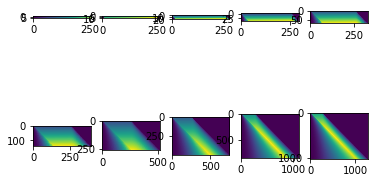

In [91]:
fig, axs = subplots(2,5)
for iax, ax in enumerate(axs.flatten()):
    ax.imshow(fredda_states[iax][0, :, :] )

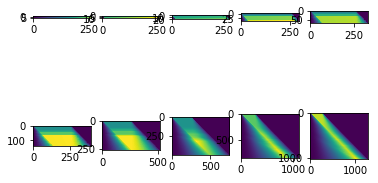

In [92]:
fig, axs = subplots(2,5)
for iax, ax in enumerate(axs.flatten()):
    ax.imshow(py_states[iax][0, :, :] )

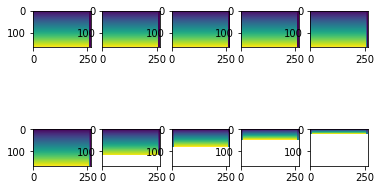

In [93]:
fig, axs = subplots(2,5)
for idm, ax in enumerate(axs.flatten()):
    ax.imshow(py_states[1][:, idm, :] )

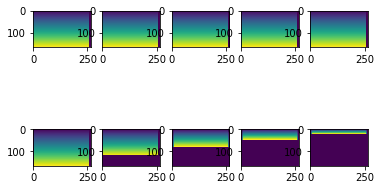

In [94]:
fig, axs = subplots(2,5)
for idm, ax in enumerate(axs.flatten()):
    ax.imshow(fredda_states[1][:, idm, :])

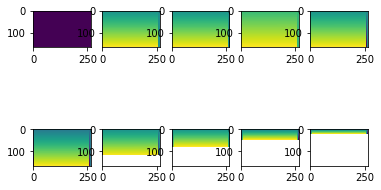

In [95]:
fig, axs = subplots(2,5)
for idm, ax in enumerate(axs.flatten()):
    ax.imshow(fredda_states[1][:, idm, :] - py_states[1][:, idm, :])


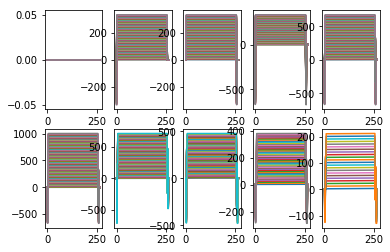

In [96]:
fig, axs = subplots(2,5)
s1diff = fredda_states[1] - py_states[1]
for idm, ax in enumerate(axs.flatten()):
    ax.plot(s1diff[:, idm, :].T)

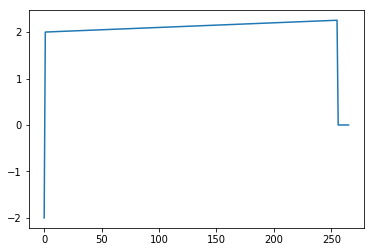

In [97]:
_ = plot(s1diff[1, 1, :].T)

In [98]:
iter = 1
ichan=1
idt=1
f_start, f_end, f_middle, f_middle_larger, delta_t_local, chanconfig = thefdmt.hist_nf_data[iter][ichan]

config = chanconfig[idt]
_, id1, offset, id2, _, _, _ = config
print('F_start', f_start, 'f_end', f_end, 'f_middle', f_middle, 'f_middle_larger', f_middle_larger)
print('iter', iter, 'ichan', ichan, 'idt', idt, 'id1', id1, 'id2', id2, 'offset', offset)

F_start 1115.5 f_end 1119.5 f_middle 1117.0 f_middle_larger 1118.0
iter 1 ichan 1 idt 1 id1 0 id2 0 offset 1


In [99]:
fch1

1112.0